# 1. Setup

## 1.1 Install Dependencies

In [ ]:
#!pip install tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib

In [ ]:
import tensorflow as tf
print(tf.__version__)


## 1.2 Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Set memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is available")
else:
    print("No GPU available, running on CPU")

GPU is available


## 1.4 Create Folder Structures

In [4]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [12]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

In [ ]:
#!tar -xf lfw.tgz

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
#for directory in os.listdir('lfw'):
    #for file in os.listdir(os.path.join('lfw', directory)):
        #EX_PATH = os.path.join('lfw', directory, file)
        #NEW_PATH = os.path.join(NEG_PATH, file)
        #os.replace(EX_PATH, NEW_PATH)

In [13]:
# Import uuid library to generate unique image names
import uuid

In [14]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\005bc5f6-b10f-11ee-8800-7c10c9268e7f.jpg'

## 2.2 Collect Positive and Anchor Classes

In [ ]:
#Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 

    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [15]:
plt.imshow(frame[120:120+250,200:200+250, :])

NameError: name 'frame' is not defined

# 2.x NEW - Data Augmentation

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data\\anchor\\9e782d75-afdd-11ee-b522-ec2e98efdbd6.jpg'


## 3.2 Preprocessing - Scale and Resize

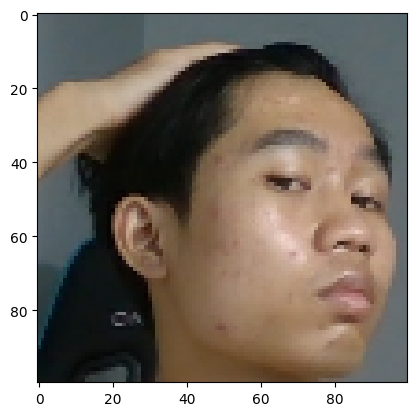

In [19]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img
img = preprocess('data\\anchor\\a4f4c74c-afdd-11ee-8885-ec2e98efdbd6.jpg')
img.numpy().max() 
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data\\anchor\\9c211da4-afdd-11ee-b476-ec2e98efdbd6.jpg',
 b'data\\positive\\38331fac-afdd-11ee-b4c2-ec2e98efdbd6.jpg',
 1.0)

## 3.4 Build Train and Test Partition

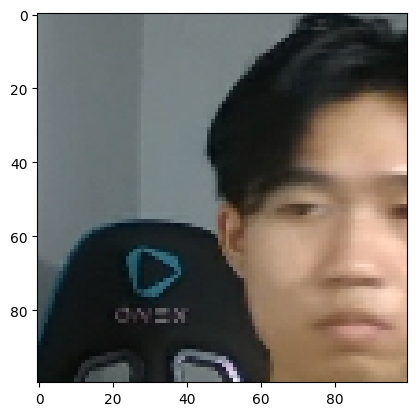

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*example)
plt.imshow(res[1])
res[2]
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [24]:
inp = Input(shape=(105,105,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D (64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [25]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.3 Make Siamese Model

In [27]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier
print(classifier)
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (Non

In [28]:
def make_siamese_model():
    input_image = input(name='input_img', shape=(100,100,3))
    validation_image = input(name='validation_img', shape=(100, 100, 3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [29]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 5.1 Setup Loss and Optimizer

In [30]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.2 Establish Checkpoints

## 5.3 Build Train Step Function

In [32]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [33]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [34]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 5.5 Train the model

In [42]:

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/3 [===================>..........] - ETA: 0s Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)



KeyboardInterrupt



In [43]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
def train(data, EPOCHS):
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []

    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)

        train_losses.append(loss.numpy())
        train_accuracies.append(r.result().numpy())
        train_precisions.append(p.result().numpy())
        train_recalls.append(r.result().numpy())

        print("Loss: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
            loss.numpy(), r.result().numpy(), p.result().numpy(), r.result().numpy()))

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    return train_losses, train_accuracies, train_precisions, train_recalls
EPOCHS = 50

In [44]:
train_losses, train_accuracies, train_precisions, train_recalls = train(train_data, EPOCHS)


 Epoch 1/50
3/3 [==============================] - 4s 2s/step
Loss: 0.4569, Accuracy: 0.1111, Precision: 1.0000, Recall: 0.1111

 Epoch 2/50
3/3 [==============================] - 2s 570ms/step
Loss: 0.4931, Accuracy: 0.1111, Precision: 1.0000, Recall: 0.1111

 Epoch 3/50
3/3 [==============================] - 2s 569ms/step
Loss: 0.4444, Accuracy: 0.1765, Precision: 1.0000, Recall: 0.1765

 Epoch 4/50
3/3 [==============================] - 2s 568ms/step
Loss: 0.1886, Accuracy: 0.3889, Precision: 1.0000, Recall: 0.3889

 Epoch 5/50
3/3 [==============================] - 2s 565ms/step
Loss: 0.4015, Accuracy: 0.5556, Precision: 1.0000, Recall: 0.5556

 Epoch 6/50
3/3 [==============================] - 2s 563ms/step
Loss: 0.1370, Accuracy: 0.6667, Precision: 1.0000, Recall: 0.6667

 Epoch 7/50
3/3 [==============================] - 2s 565ms/step
Loss: 0.2439, Accuracy: 0.9000, Precision: 1.0000, Recall: 0.9000

 Epoch 8/50
3/3 [==============================] - 2s 569ms/step
Loss: 0.1690,

# 6. Evaluate Model

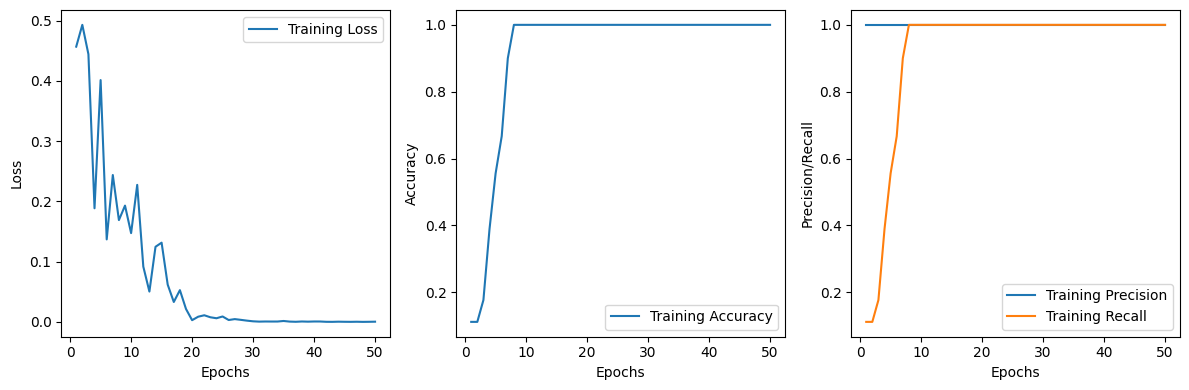

In [45]:
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_precisions, label='Training Precision')
plt.plot(epochs_range, train_recalls, label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Precision/Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
#!pip install scikit-learn

from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate(data):
    y_true = []
    y_pred = []

    for batch in data:
        X = batch[:2]
        labels = batch[2]

        predictions = siamese_model.predict(X)
        binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

        y_true.extend(labels.numpy())
        y_pred.extend(binary_predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return accuracy, precision, recall


In [47]:
accuracy, precision, recall = evaluate(test_data)

print("Test Accuracy: {:.2%}".format(accuracy))
print("Test Precision: {:.2%}".format(precision))
print("Test Recall: {:.2%}".format(recall))

1/1 [==============================] - 0s 329ms/step
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%


1/1 [==============================] - 0s 63ms/step


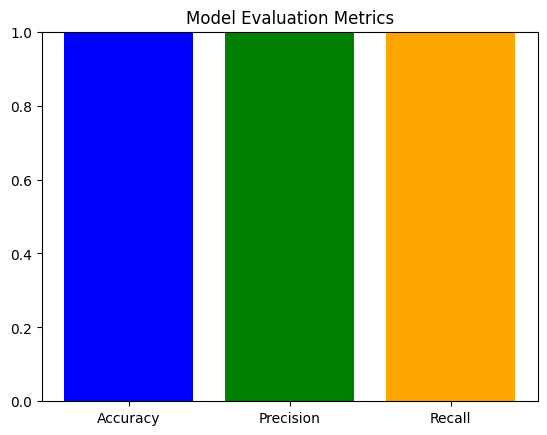

In [48]:
import matplotlib.pyplot as plt

def plot_evaluation_metrics(accuracy, precision, recall):
    labels = ['Accuracy', 'Precision', 'Recall']
    values = [accuracy, precision, recall]

    plt.bar(labels, values, color=['blue', 'green', 'orange'])
    plt.ylim(0, 1)  # Skala y-axis dari 0 hingga 1
    plt.title('Model Evaluation Metrics')
    plt.show()

# Anda perlu memanggil fungsi plot_evaluation_metrics dengan hasil evaluasi Anda
accuracy, precision, recall = evaluate(test_data)
plot_evaluation_metrics(accuracy, precision, recall)


## 6.1 Import Metrics

## 6.2 Make Predictions

In [49]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 63ms/step


array([[5.4089585e-05],
       [3.9410202e-06],
       [3.7161936e-04],
       [9.9955457e-01],
       [9.9988246e-01],
       [9.9949002e-01],
       [9.9896896e-01],
       [2.1744047e-05],
       [9.2958966e-05],
       [2.5258181e-05],
       [5.7824536e-07],
       [6.1696278e-06],
       [2.7881128e-05],
       [2.5376969e-04],
       [9.9981385e-01],
       [6.4109563e-06]], dtype=float32)

In [50]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [51]:
y_true

array([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [52]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [53]:
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [54]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 58ms/step
1.0 1.0


## 6.4 Viz Results

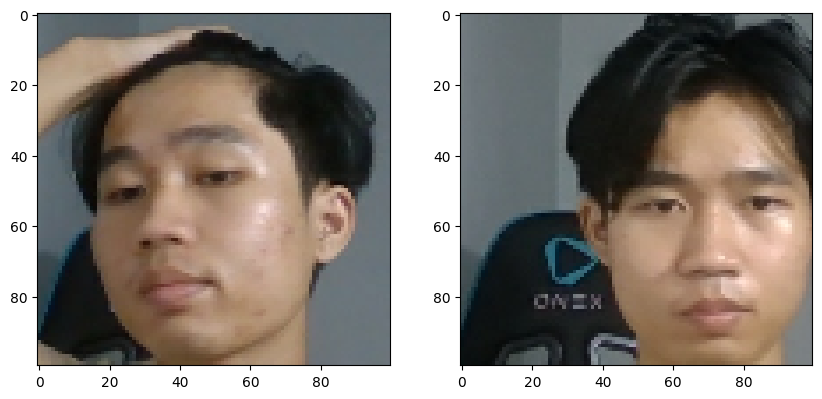

In [57]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [58]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [59]:
L1Dist

__main__.L1Dist

In [60]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

model.predict([test_input, test_val])

1/1 [==============================] - 0s 349ms/step


array([[1.9753654e-06],
       [9.9999404e-01],
       [9.9896920e-01]], dtype=float32)

In [61]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

In [62]:
import os

In [63]:
os.listdir(os.path.join('application_data', 'verification_images'))

['26718183-afdd-11ee-9c33-ec2e98efdbd6.jpg',
 '282b7902-afdd-11ee-aa96-ec2e98efdbd6.jpg',
 '2907330d-afdd-11ee-8098-ec2e98efdbd6.jpg',
 '363779a5-afdd-11ee-8009-ec2e98efdbd6.jpg',
 '36f10c1d-afdd-11ee-b18c-ec2e98efdbd6.jpg',
 '370b3794-afdd-11ee-84aa-ec2e98efdbd6.jpg',
 '376f4379-afdd-11ee-93c9-ec2e98efdbd6.jpg',
 '378b99a5-afdd-11ee-9356-ec2e98efdbd6.jpg',
 '37a88763-afdd-11ee-a129-ec2e98efdbd6.jpg',
 '38331fac-afdd-11ee-b4c2-ec2e98efdbd6.jpg',
 '3879497f-afdd-11ee-82ba-ec2e98efdbd6.jpg',
 '39853a30-afdd-11ee-af11-ec2e98efdbd6.jpg',
 '3a43ad02-afdd-11ee-8b12-ec2e98efdbd6.jpg',
 '3a659e71-afdd-11ee-9dd2-ec2e98efdbd6.jpg',
 '3a86d308-afdd-11ee-a396-ec2e98efdbd6.jpg',
 '3aa804de-afdd-11ee-b5d8-ec2e98efdbd6.jpg',
 '3ae6370a-afdd-11ee-bcfc-ec2e98efdbd6.jpg',
 '3b07fada-afdd-11ee-a997-ec2e98efdbd6.jpg',
 '3b26f058-afdd-11ee-9533-ec2e98efdbd6.jpg',
 '3bc95d78-afdd-11ee-aee9-ec2e98efdbd6.jpg',
 '3c51830d-afdd-11ee-b312-ec2e98efdbd6.jpg',
 '9a342a9a-afdd-11ee-aa51-ec2e98efdbd6.jpg',
 '9adf7be3

In [64]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

## 8.1 Verification Function

In [65]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\26718183-afdd-11ee-9c33-ec2e98efdbd6.jpg
application_data\verification_images\282b7902-afdd-11ee-aa96-ec2e98efdbd6.jpg
application_data\verification_images\2907330d-afdd-11ee-8098-ec2e98efdbd6.jpg
application_data\verification_images\363779a5-afdd-11ee-8009-ec2e98efdbd6.jpg
application_data\verification_images\36f10c1d-afdd-11ee-b18c-ec2e98efdbd6.jpg
application_data\verification_images\370b3794-afdd-11ee-84aa-ec2e98efdbd6.jpg
application_data\verification_images\376f4379-afdd-11ee-93c9-ec2e98efdbd6.jpg
application_data\verification_images\378b99a5-afdd-11ee-9356-ec2e98efdbd6.jpg
application_data\verification_images\37a88763-afdd-11ee-a129-ec2e98efdbd6.jpg
application_data\verification_images\38331fac-afdd-11ee-b4c2-ec2e98efdbd6.jpg
application_data\verification_images\3879497f-afdd-11ee-82ba-ec2e98efdbd6.jpg
application_data\verification_images\39853a30-afdd-11ee-af11-ec2e98efdbd6.jpg
application_data\verification_images\3a43ad02-afdd-11ee-8b12-ec2

## 8.2 OpenCV Real Time Verification

In [66]:
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def verify( model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [67]:
cap = cv2.VideoCapture(0)
cv2.imshow('Verification', cap.read()[1])
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
44/50